In [38]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define Steam App IDs
games = {
    "Counter-Strike 2": "730",
    "Dota 2": "570",
    "PUBG": "578080",
    "Apex Legends": "1172470",
    "Rust": "252490",
    "Cyberpunk 2077": "1091500",
    "Terraria": "105600"
}

# steamcharts url
base_url = "https://steamcharts.com/app/{}/"

# list to store data
all_data = []


def get_data(game_name, app_id):
    url = base_url.format(app_id)
    response = requests.get(url)
    
    # generate soup object
    soup = BeautifulSoup(response.text, "html.parser")

    table = soup.find("table", class_="common-table")
    if not table:
        print(f"No historical data table found for {game_name}.")
        return

    rows = table.find_all("tr")[1:]

    for row in rows:
        cols = row.find_all("td")
        if len(cols) < 4:
            continue

        month = cols[0].text.strip()
        avg_players = cols[1].text.strip().replace(",", "")

        try:
            avg_players = float(avg_players)
            all_data.append([game_name, month, avg_players])
        except ValueError:
            continue

for game, app_id in games.items():
    get_data(game, app_id)
    time.sleep(2)  # sleep for 2 seconds to respect website traffic flow

# convert to pandas dataframe
df = pd.DataFrame(all_data, columns=["Game", "Month", "Avg Players"])

In [39]:
df.head()

,Game,Month,Avg Players
0,Counter-Strike 2,Last 30 Days,1020499.87
1,Counter-Strike 2,February 2025,1003570.56
2,Counter-Strike 2,January 2025,914092.22
3,Counter-Strike 2,December 2024,913953.36
4,Counter-Strike 2,November 2024,852164.30


In [40]:
# Seperate our data into different dataframes for each game
game_dfs = {}

for game in df["Game"].unique():
    game_df = df[df["Game"] == game].copy()
    game_dfs[game] = game_df


In [41]:
def clean_game_data(df):

    # Remove first row due to odd month (last 30 days)
    df = df.iloc[1:].reset_index(drop=True)

    # Convert "Month" to datetime
    df["Month"] = pd.to_datetime(df["Month"], format="mixed")

    # sort from oldest to newest data
    df = df.sort_values("Month").reset_index(drop=True)

    # caluclate percent growth from previous month
    df["Growth"] = df["Avg Players"].pct_change() * 100 

    # remove first and last row (invalid growth)
    df = df.iloc[1:-1].reset_index(drop=True)

    return df

for game in game_dfs:
    game_dfs[game] = clean_game_data(game_dfs[game])

In [42]:
cleaned_df = pd.concat(game_dfs.values(), ignore_index=True)

In [43]:
cleaned_df.tail()

,Game,Month,Avg Players,Growth
771,Terraria,2024-09-01,22638.40,-15.209572
772,Terraria,2024-10-01,22679.99,0.183714
773,Terraria,2024-11-01,22429.16,-1.105953
774,Terraria,2024-12-01,28796.58,28.389026
775,Terraria,2025-01-01,29151.93,1.234001


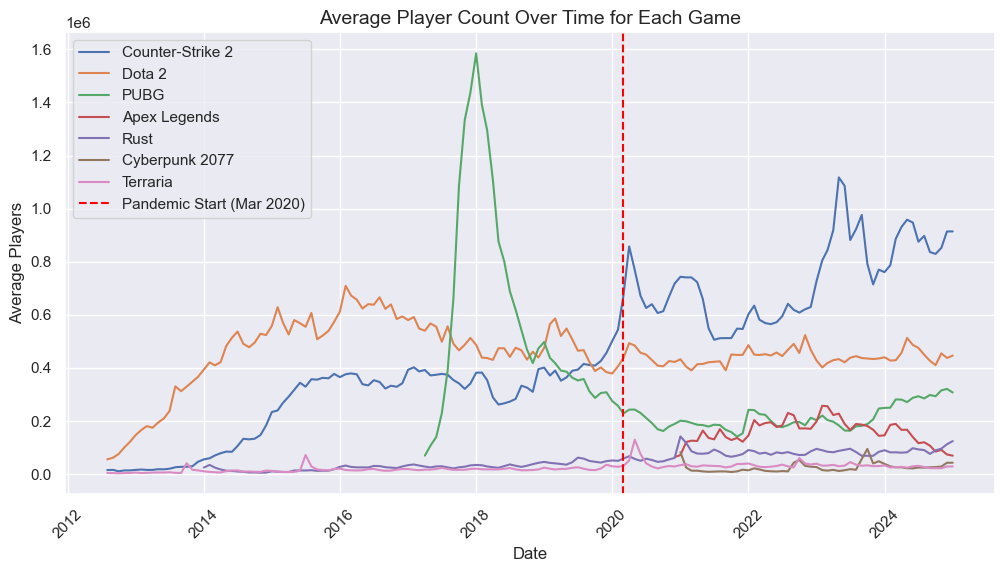

In [44]:
# graph based upon player count over time for our games

def plot_avg_players(data):
    unique_games = data["Game"].unique()
    
    plt.figure(figsize=(12, 6))
    
    for game in unique_games:
        subset = data[data["Game"] == game]
        plt.plot(subset["Month"], subset["Avg Players"], label=game)
    
    pandemic_start = pd.to_datetime("2020-03-01")
    plt.axvline(x=pandemic_start, color="red", linestyle="--", label="Pandemic Start (Mar 2020)")
    
    plt.title("Average Player Count Over Time for Each Game", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Average Players", fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_avg_players(cleaned_df)


In [45]:
# multiplayer games vs non multiplayer games
multiplayer_games = ["Counter-Strike 2", "Dota 2", "PUBG", "Apex Legends", "Rust"]
non_multiplayer_games = ["Cyberpunk 2077", "Terraria"]

# new df column for game type
cleaned_df["Game Type"] = cleaned_df["Game"].apply(
    lambda x: "Multiplayer" if x in multiplayer_games else "Non-Multiplayer"
)


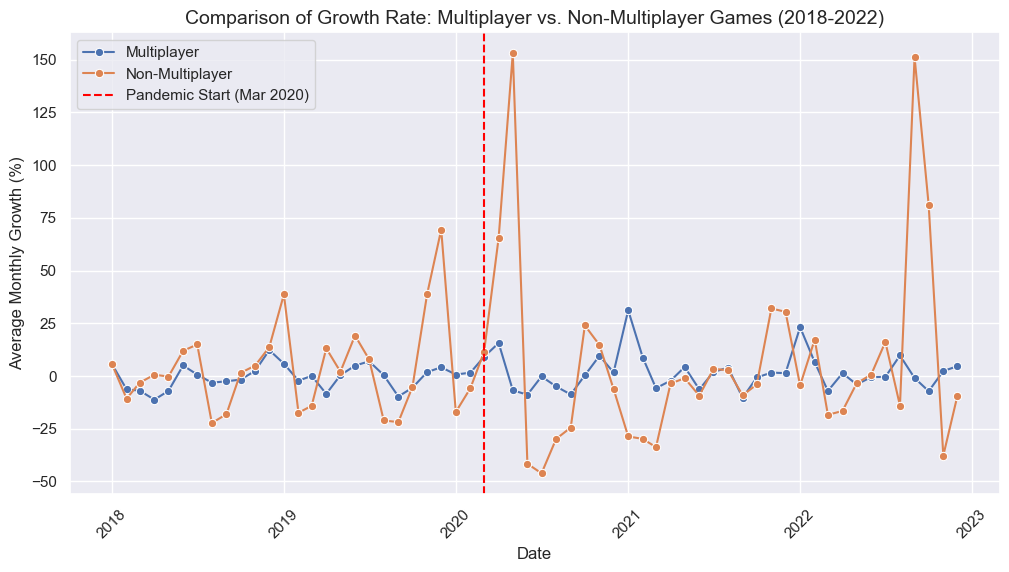

In [46]:
def plot_growth_comparison(data):
    
    filtered_data = data[(data["Month"] >= "2018-01-01") & (data["Month"] <= "2022-12-31")]

    plt.figure(figsize=(12, 6))

    grouped_data = filtered_data.groupby(["Month", "Game Type"])["Growth"].mean().reset_index()

    sns.lineplot(data=grouped_data, x="Month", y="Growth", hue="Game Type", marker="o")

    pandemic_start = pd.to_datetime("2020-03-01")
    plt.axvline(x=pandemic_start, color="red", linestyle="--", label="Pandemic Start (Mar 2020)")

    plt.title("Comparison of Growth Rate: Multiplayer vs. Non-Multiplayer Games (2018-2022)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Average Monthly Growth (%)", fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_growth_comparison(cleaned_df)

C:\Users\potat\AppData\Local\Temp\ipykernel_964\893408668.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Game", y="Total Growth (%)", data=growth_2016_2020, palette="Blues")


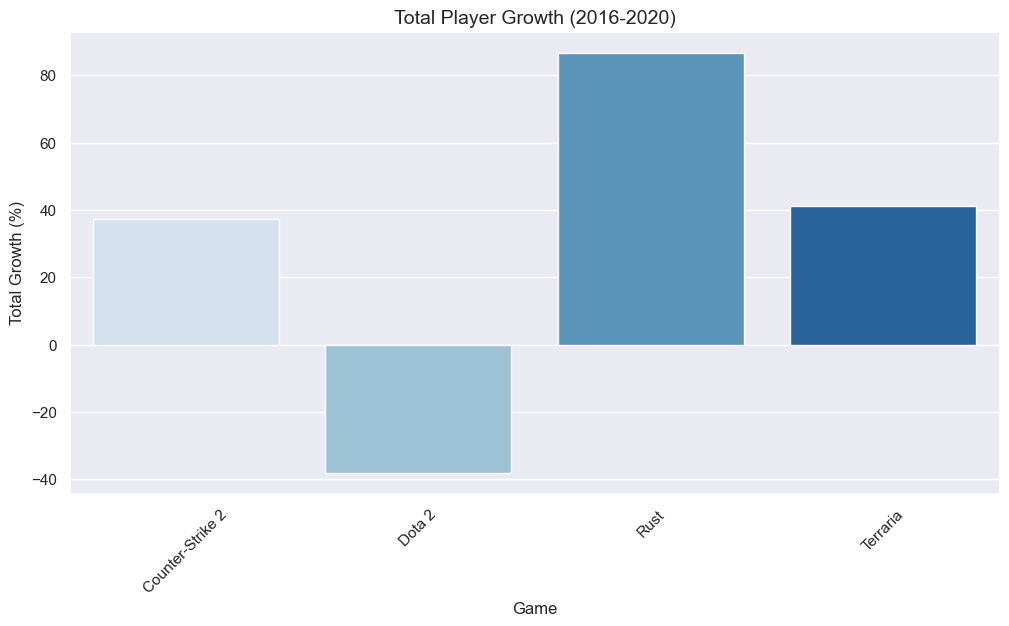

C:\Users\potat\AppData\Local\Temp\ipykernel_964\893408668.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Game", y="Total Growth (%)", data=growth_2020_2024, palette="Oranges")


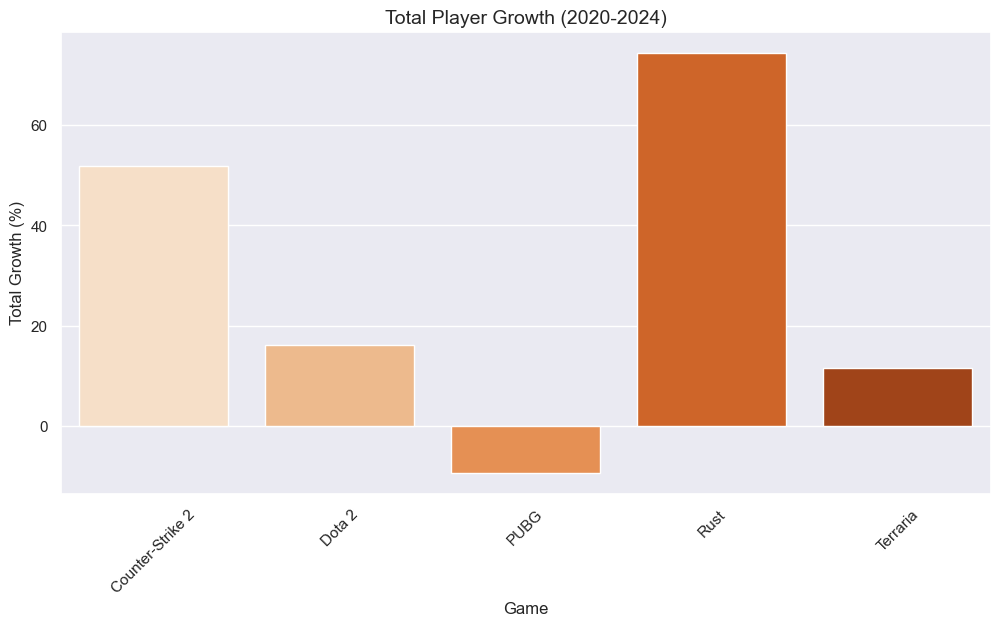

In [47]:
def plot_total_growth_separate(data):
    
    # Filter data for 2016-2020 and 2020-2024
    start_period = data[data["Month"] == "2016-01-01"]
    mid_period = data[data["Month"] == "2020-01-01"]
    end_period = data[data["Month"] == "2024-01-01"]

    # Merge data to calculate total growth
    growth_2016_2020 = start_period.merge(mid_period, on="Game", suffixes=("_2016", "_2020"))
    growth_2020_2024 = mid_period.merge(end_period, on="Game", suffixes=("_2020", "_2024"))

    # Calculate total growth in both periods
    growth_2016_2020["Total Growth (%)"] = ((growth_2016_2020["Avg Players_2020"] - growth_2016_2020["Avg Players_2016"]) / growth_2016_2020["Avg Players_2016"]) * 100
    growth_2020_2024["Total Growth (%)"] = ((growth_2020_2024["Avg Players_2024"] - growth_2020_2024["Avg Players_2020"]) / growth_2020_2024["Avg Players_2020"]) * 100

    # Plot 2016-2020 Growth
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Game", y="Total Growth (%)", data=growth_2016_2020, palette="Blues")
    plt.title("Total Player Growth (2016-2020)", fontsize=14)
    plt.xlabel("Game", fontsize=12)
    plt.ylabel("Total Growth (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

    # Plot 2020-2024 Growth
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Game", y="Total Growth (%)", data=growth_2020_2024, palette="Oranges")
    plt.title("Total Player Growth (2020-2024)", fontsize=14)
    plt.xlabel("Game", fontsize=12)
    plt.ylabel("Total Growth (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

plot_total_growth_separate(cleaned_df)

In [50]:
cleaned_df.to_csv("steam_cleaned_dataset.csv", index=False)